# **Modelling and Evaluation C**

## Objectives

* Answer Business requirement 2:
    * The client wants to be able to know from the MRI brain scan if a patient has a tumor or not.

## Inputs

* input/train
* input/test
* input/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Saved model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file. 

## Additional Comments

* First two models didn't give satisfactory results. We decided to try different approach to the modelhyperparameters optimizing
* We are selecting Hyperband tuner


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/tom/codeinstitute/brain-tumor-detect/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
working_dir = os.getcwd()
working_dir

'/home/tom/codeinstitute/brain-tumor-detect'

# Import regular packages

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set input directories

Set train, validation and test paths

In [5]:
input_dir = 'input'
train_path = os.path.join(input_dir, 'train')
test_path = os.path.join(input_dir, 'test')
validation_path = os.path.join(input_dir, 'validation')


# Set ouput directory

In [6]:
version = 'v4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(os.path.join(working_dir, 'outputs')):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

# Set lables

In [7]:
labels = os.listdir(train_path)
print(f'Project lables: {labels}')

Project lables: ['mri-tumor', 'mri-non-tumor']


# Load image shape

## Import saved image shape embedding

In [8]:
import joblib
image_shape = joblib.load(filename=f'outputs/{version}/image_shape.pkl')
image_shape

(240, 240, 3)

# Number of images in train, test and validation data sets and their respective data balance

* train - mri-tumor: 1178 images
* train - mri-non-tumor: 1455 images
* validation - mri-tumor: 169 images
* validation - mri-non-tumor: 209 images
* test - mri-tumor: 336 images
* test - mri-non-tumor: 415 images


Total dataset balance report:
Label - mri-non-tumor: 2079 images
Label - mri-tumor: 1683 images





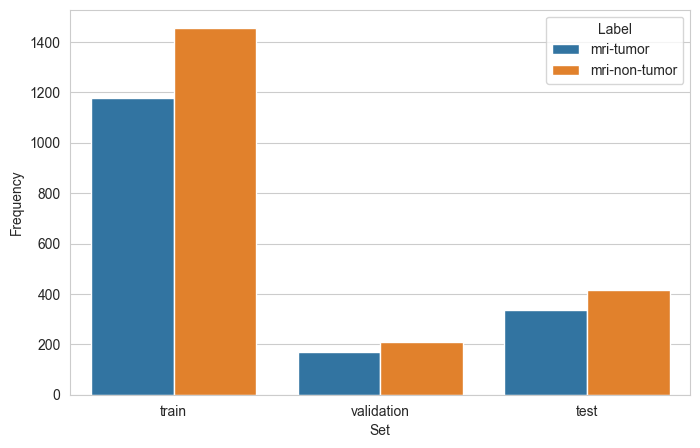

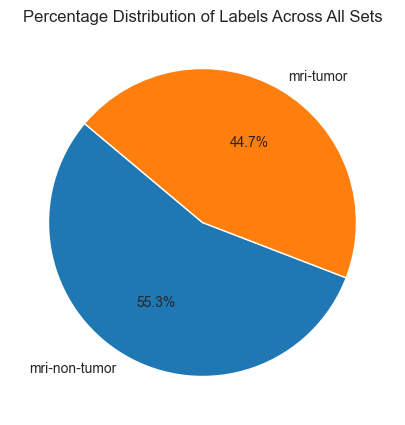

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(os.path.join(input_dir, folder, label))))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(os.path.join(input_dir, folder, label)))} images")

print("\n")

# Aggregating the frequencies of labels across all sets
total_label_distribution = df_freq.groupby('Label')['Frequency'].sum()


# Creating a report
report = "Total dataset balance report:\n"
for label, count in total_label_distribution.items():
    report += f"Label - {label}: {int(count)} images\n"

# Printing the report
print(report)
print("\n")

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Create a pie chart
plt.figure(figsize=(8, 5))
total_label_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Labels Across All Sets')
plt.ylabel('')  # Hide the y-label

# Save the pie chart
plt.savefig(os.path.join(file_path, 'label_distribution_across_all_sets.png'), bbox_inches='tight', dpi=150)
plt.show()

From the diagram we can observe that the datasets are imbalanced. We will procede with data augmentation, and, if necessary, with over sampling the mri-tumor datasets.

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Image Data Augmentation

---

## Import ImageDataGenerator from tensorflow library

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We will then setup the pipeline for the image data generator

In [11]:
from keras.preprocessing.image import ImageDataGenerator
augmentation_data = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    shear_range = 15,
    fill_mode='nearest',
    rescale=1.0/255.0,
)


## Augmentation of the training image dataset

In [12]:
batch_size = 20 
train_set = augmentation_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2633 images belonging to 2 classes.


{'mri-non-tumor': 0, 'mri-tumor': 1}

## Augmentation of the validation image dataset

In [13]:
validation_set = augmentation_data.flow_from_directory(validation_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

validation_set.class_indices

Found 378 images belonging to 2 classes.


{'mri-non-tumor': 0, 'mri-tumor': 1}

## Augmentation of the test image dataset

In [14]:
test_set = augmentation_data.flow_from_directory(test_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 751 images belonging to 2 classes.


{'mri-non-tumor': 0, 'mri-tumor': 1}

---

## Plot augmented training images

(20, 240, 240, 3)


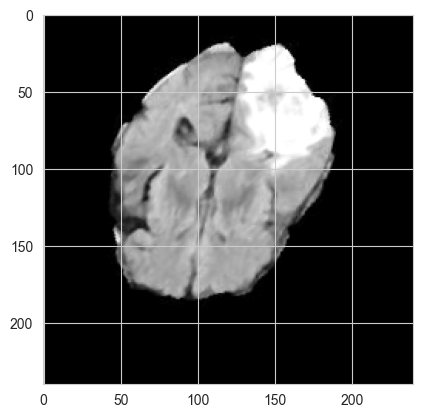

(20, 240, 240, 3)


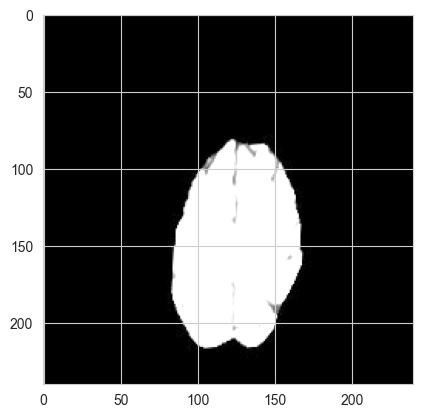

(20, 240, 240, 3)


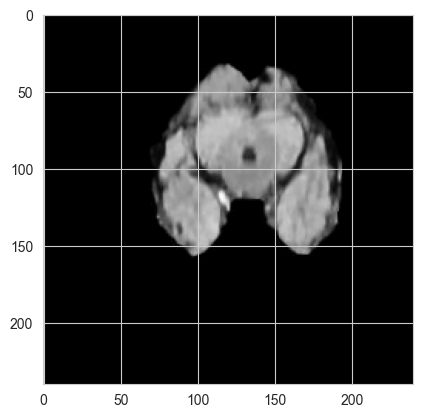

(20, 240, 240, 3)


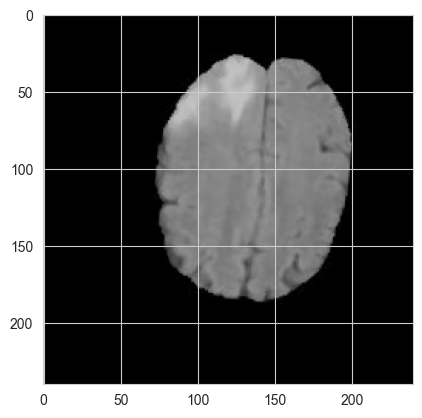

(20, 240, 240, 3)


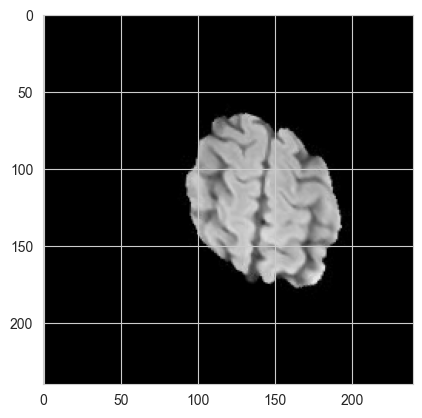

In [15]:
for i in range(5):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation images

(20, 240, 240, 3)


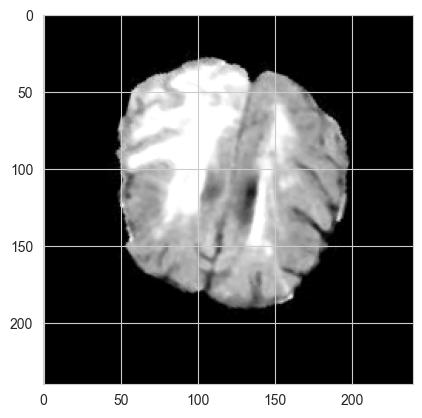

(20, 240, 240, 3)


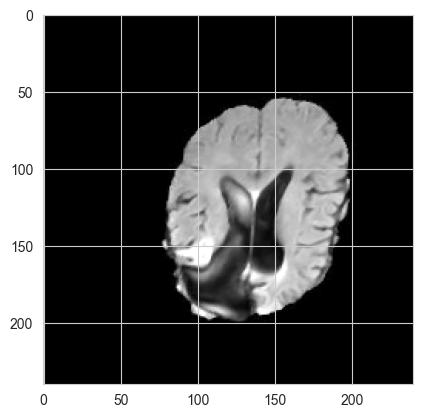

(20, 240, 240, 3)


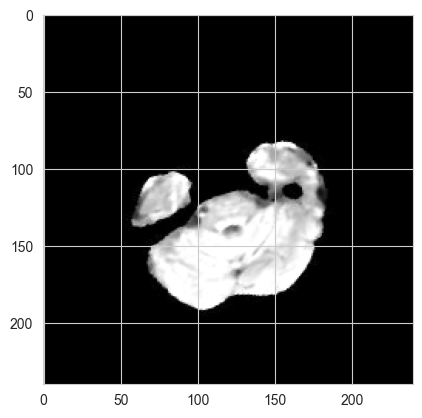

(20, 240, 240, 3)


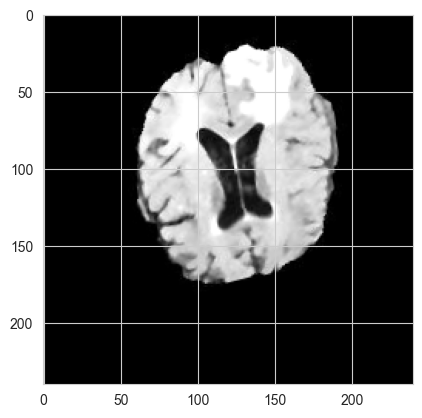

(20, 240, 240, 3)


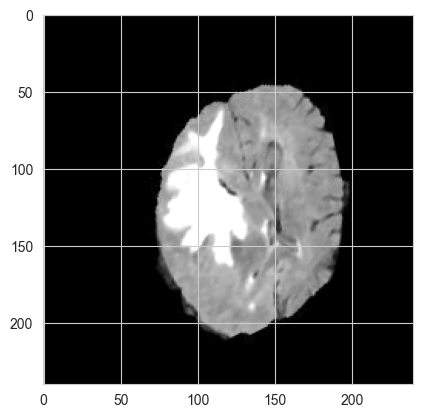

In [16]:
for i in range(5):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot augmented test images

(20, 240, 240, 3)


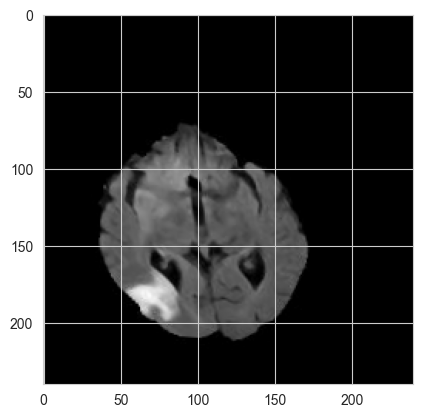

(20, 240, 240, 3)


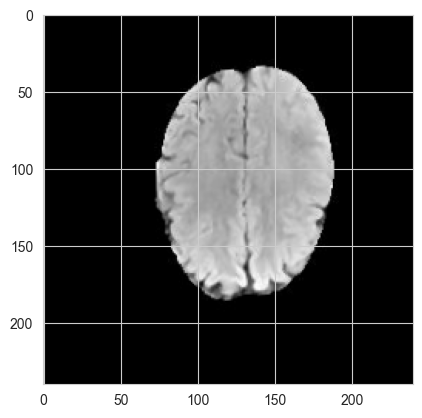

(20, 240, 240, 3)


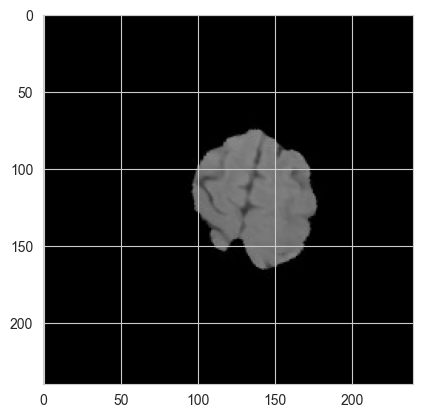

(20, 240, 240, 3)


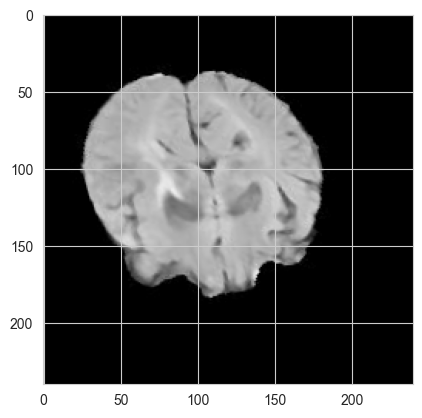

(20, 240, 240, 3)


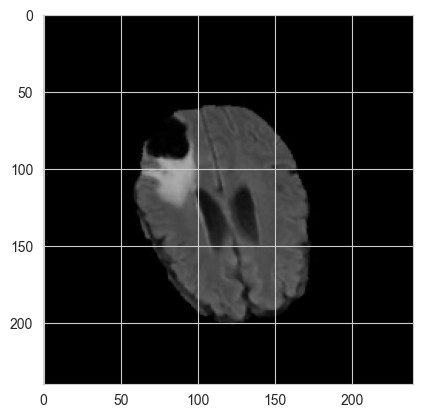

In [17]:
for i in range(5):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

# Save class indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v4/class_indices.pkl']

# Model Creation

Install Keras Tuner

In [19]:
!pip install keras-tuner


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


## Import model packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Building Model Function

In [21]:
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

## Hyperparameter Tuning with Keras Tuner

Import Keras Tuner function

In [22]:
from tensorflow import keras
from keras_tuner import Hyperband

In [24]:
# Define the tuner Random Search
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='mri_tumor_tuning'
)

2024-01-04 13:42:53.912712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Early stopping

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Implementing Class Weights from Keras for the balancing of the dataset

In [26]:
from sklearn.utils import class_weight
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_set.classes),
                                                  train_set.classes)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

/home/tom/codeinstitute/brain-tumor-detect/venv/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.9048109965635739, 1: 1.117572156196944}

Solve a memory problem
* 2024-01-03 22:35:11.587342: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 398114816 exceeds 10% of free system memory.

In [27]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [28]:
# Search for the best hyperparameters
tuner.search(train_set,
             epochs=25,
             steps_per_epoch=len(train_set.classes) // batch_size,
             validation_data=validation_set,
             class_weight=class_weights_dict,
             callbacks=[early_stop],
             verbose=2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 22 Complete [00h 35m 51s]
val_accuracy: 0.7936508059501648

Best val_accuracy So Far: 0.8148148059844971
Total elapsed time: 09h 01m 07s
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 128 and the optimal learning rate for the optimizer is 0.001.


Create Model with the best hyperparameters

In [29]:
model = tuner.hypermodel.build(best_hps)

## Model Summary

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

## Fit model for training

In [31]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
131/131 [==============================] - 458s 3s/step - loss: 0.5670 - accuracy: 0.7160 - val_loss: 0.5120 - val_accuracy: 0.7566
Epoch 2/25
131/131 [==============================] - 526s 4s/step - loss: 0.5121 - accuracy: 0.7539 - val_loss: 0.4625 - val_accuracy: 0.7963
Epoch 3/25
131/131 [==============================] - 485s 4s/step - loss: 0.4872 - accuracy: 0.7688 - val_loss: 0.4498 - val_accuracy: 0.7989
Epoch 4/25
131/131 [==============================] - 602s 5s/step - loss: 0.4944 - accuracy: 0.7650 - val_loss: 0.4601 - val_accuracy: 0.7751
Epoch 5/25
131/131 [==============================] - 576s 4s/step - loss: 0.4987 - accuracy: 0.7600 - val_loss: 0.4611 - val_accuracy: 0.7857
Epoch 6/25
131/131 [==============================] - 571s 4s/step - loss: 0.4773 - accuracy: 0.7792 - val_loss: 0.4516 - val_accuracy: 0.7937


## Save Model

In [32]:
model.save(f'outputs/{version}/brain_tumor_detect_model.h5')

---

# Model Performance

Model learning curve

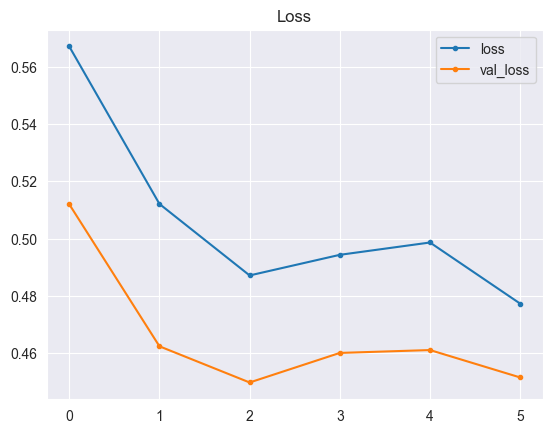

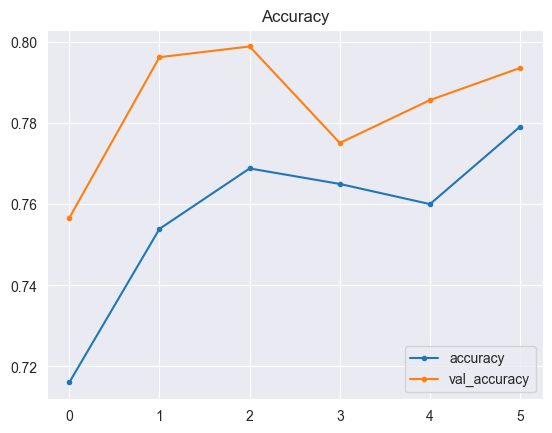

In [33]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight',
            dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight',
            dpi=150)
plt.show()

# Model Evaluation

In [34]:
from tensorflow.keras.models import load_model
model = load_model(f'outputs/{version}/brain_tumor_detect_model.h5')

Evaluate saved model on test set

In [35]:
evaluation = model.evaluate(test_set)

38/38 [==============================] - 48s 1s/step - loss: 0.4954 - accuracy: 0.7550


Save evaluation pickle

In [36]:
joblib.dump(value=evaluation,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v4/evaluation.pkl']

In [37]:
labels

['mri-tumor', 'mri-non-tumor']

## Model Evaluation - Confusion Matrix

[[224 191]
 [162 174]]
               precision    recall  f1-score   support

    mri-tumor       0.58      0.54      0.56       415
mri-non-tumor       0.48      0.52      0.50       336

     accuracy                           0.53       751
    macro avg       0.53      0.53      0.53       751
 weighted avg       0.53      0.53      0.53       751



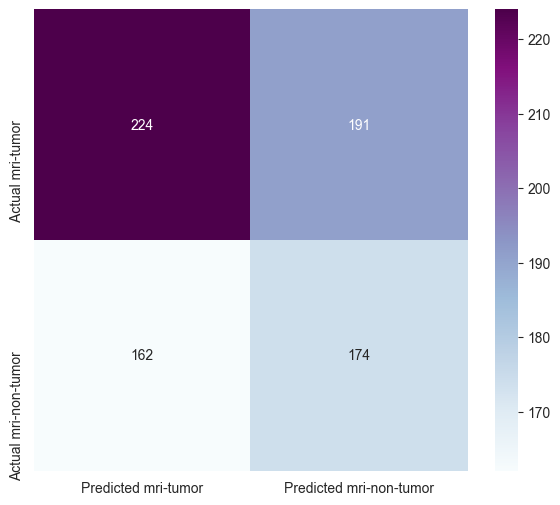

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
pred = model.predict(test_set)
y_pred = np.concatenate(np.round(pred).astype(int))
target_names = labels
confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print(confusion_matrix)
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            cmap='BuPu',
            xticklabels=['Predicted mri-tumor', 'Predicted mri-non-tumor'],
            yticklabels=[' Actual mri-tumor', 'Actual mri-non-tumor'],)
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
print(classification_report(test_set.classes, y_pred, 
      target_names=target_names))

## Predict on new data

Load a random image as PIL

Image shape: (240, 240), Image mode: RGB


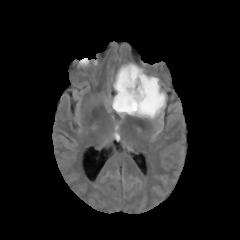

In [42]:
from tensorflow.keras.preprocessing import image
import os

pointer = 39
label = labels[0]

image_path = os.path.join(test_path, label, os.listdir(os.path.join(test_path, label))[pointer])

pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediciton

In [43]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 240, 240, 3)


Predict class probabilities

In [44]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.8537544
mri-tumor
